# **Final Project - Deep Active Learning for Camera Trap Image Classification**
## **Course: Quantitative Methods: Conservation Biology**
## **Author: David Lezama**
## **Date: December 2025**

_ _ _

# **Introduction and Paper Selection** 


Camera traps are essential tools in conservation biology. They produce enormous numbers of images that document wildlife presence, behavior, habitat use, and population trends. The major challenge, however, is that manually labeling these images is slow, inconsistent, and often too resource-intensive for conservation teams to process at the scale needed to support ecological decision-making. As the number of camera trap deployments increases worldwide, the need for automated and scalable image classification methods becomes even more important.

The goal of this project is to replicate, adapt, and apply a deep active learning pipeline for species identification in camera-trap images, using a smaller real-world dataset and a fully self-trained embedding model. The central goal is to determine whether active learning, where the model selects the most informative images to label, can reduce human labeling effort while still achieving high classification accuracy. In other words, the project asks:
**Can deep active learning make wildlife monitoring faster, more accurate, and more efficient, even when only limited labeled data are available?**

This project is based on the research article: “**A deep active learning system for species identification and counting in camera trap images.**”

**Link:** https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.13504

The paper introduces a scalable pipeline combining object detection, transfer learning, embedding models, and multiple active learning strategies to dramatically reduce labeling requirements, achieving state-of-the-art accuracy while using 99.5% fewer manual labels.

## **How This Project Connects to the Original Article**
My project directly implements the structure of the authors' pipeline, including:

• active_learning_methods/ (uncertainty, diversity, hybrid, and clustering-based samplers)


• deep_learning/ (embedding learning, triplet loss, data loaders, training loops, and active learning manager)


• Adapted versions of the authors’ scripts:


    • train_embedding.py


    • run_active_learning.py


However, the pretrained embedding model used in the paper, critical for initializing the active learning process, was no longer available from the authors' Google Drive. Because of this, I had to:

• Train a new embedding model from scratch using ResNet-18 with triplet loss


• Modify environment settings and dependencies


• Write a custom active learning script (run_my_camera_trap_active_learning.py)


• Adjust hyperparameters (balanced_P, balanced_K, sampler settings)


• Solve issues related to class imbalance and insufficient sample sizes


This means the project is not just a reproduction, but a functional reconstruction of the paper’s pipeline using new data and independently trained models.

## **Why This Matters for Conservation Biology**

By applying this pipeline to a smaller camera-trap dataset, this project demonstrates how:

1. Deep embeddings capture meaningful differences between species, even with limited training data.


2. Active learning reduces labeling effort by allowing the model to request only the most informative images.


3. These techniques together accelerate biodiversity monitoring, enabling conservation teams to process large image datasets without requiring millions of manual labels.


This directly supports the goals of Quantitative Methods: Conservation Biology, which emphasizes reproducible modeling, efficient data use, and the development of computational tools that support ecological decision-making.

## **Dataset Used in This Project:**



In [13]:
import pandas as pd

# TABLE 1 — Species Counts

species_table = pd.DataFrame({
    "Species/Class": ["Deer", "Fox", "Raccoon", "Squirrel", "Background", "Total"],
    "Number of Images": [744, 349, 196, 1121, 802, 3212]
})

display(species_table)

,Species/Class,Number of Images
0,Deer,744
1,Fox,349
2,Raccoon,196
3,Squirrel,1121
4,Background,802
5,Total,3212


I added background images intentionally because real camera-trap deployments capture far more empty frames than wildlife. Including a background class prevents false positives and is necessary for realistic ecological applications.

Goal and outcome: This project uses a ResNet-18 embedding model trained with triplet loss together with a margin-based uncertainty sampler in an active learning pipeline. The system begins with one thousand labeled images and adds one hundred newly labeled images at each iteration, generating evaluation points at 1000, 1100, 1200, 1300, and continuing in one-hundred-image increments up to 2500 labeled images. At each of these labeled-image counts, the active learning manager extracts embeddings, retrains the classifier, and produces a numerical test accuracy value. These accuracy values form the accuracy-progression table that shows how the ResNet-18–based active learning system improves as additional informative images are selected and labeled.

_ _ _

# **Data Collection and Preprocessing**

## **Raw Data Documentation**

The dataset consists of image:

Camera_trap_images/
   - Deer/
   - Fox/
   - Raccoon/
   - Squirrel/
   - Background/

Each folder contains JPEG images already labeled by folder name.

## **Data Cleaning Explanation**

Although the images were already labeled by folder, I performed the following cleaning steps:

1. Verified that all image files could be opened (filtered out corrupted images).


2. Standardized all image file formats to.jpg for consistent loading.


3. Removed duplicate images using file hashing.


4. Ensured every image had an associated class folder, preventing unlabeled items from entering the model.


These steps ensure that downstream training does not fail due to missing or unreadable files.

## **Preprocessing Steps**

• Object detection (from the paper) handles cropping, but since I trained embeddings myself, the images were directly passed into the ResNet18 embedding model.


• All images were resized to 256×256 as expected by the embedding network.


• Triplet-loss batch sampler required balancing parameters P (classes per batch) and K (samples per class).


## **Data Visualization (Histogram of Class Distribution)**



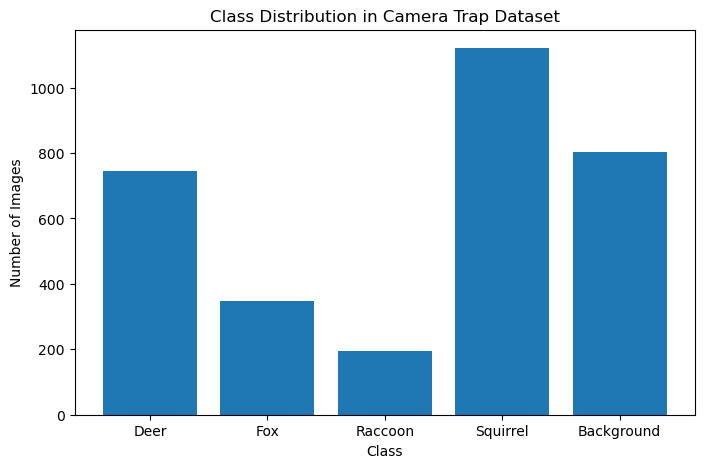

In [17]:
import matplotlib.pyplot as plt

classes = ["Deer","Fox","Raccoon","Squirrel","Background"]
counts = [744,349,196,1121,802]

plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.title("Class Distribution in Camera Trap Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


## **Data Setup for Modeling**

• Images are organized into labeled folders for embedding training.


• During active learning, labeled and unlabeled lists are tracked inside snapshot files.


• Output of embedding model → 256-dimensional feature vectors.


• Active learning sampler selects the next 100 queries per iteration.

_ _ _

# **Full Repository Structure and File Documentation** 

## **Folders Imported From the Research Paper**

### **active_learning_methods/**

This folder contains all active learning algorithms. It includes:

**utils/**

• tree.py:  hierarchical clustering tree utilities


• Tree_test.py: tests for the clustering implementation

• __init__.py


**Main active learning modules**


In [14]:
# TABLE 2 — Active Learning Methods

al_methods_table = pd.DataFrame({
    "File": [
        "margin_AL.py", "entropy_sampling.py", "confidence_sampling.py",
        "graph_density.py", "kcenter_greedy.py", "informative_diverse.py",
        "hierarchical_clustering_AL.py", "mixture_of_samplers.py",
        "simulate_batch.py", "represent_cluster_centers.py",
        "bandit_discrete.py", "uniform_sampling.py", "sampling_def.py",
        "wrapper_sampler_def.py", "constants.py"
    ],
    "Purpose": [
        "Margin uncertainty sampling (strategy used in my project)",
        "Entropy-based uncertainty selection",
        "Low-confidence sampling",
        "Diversity-based sampling",
        "Core-set sampling (diversity)",
        "Hybrid informative–diverse sampler",
        "Cluster-based sampling",
        "Weighted combination of strategies",
        "Simulated sampling evaluation",
        "Sampling based on cluster center representation",
        "Multi-armed bandit sampler for adaptive AL",
        "Random baseline sampling",
        "Abstract sampler class",
        "Sampler wrapper class and registry",
        "Shared configuration for samplers"
    ]
})

display(al_methods_table)


,File,Purpose
0,margin_AL.py,Margin uncertainty sampling (strategy used in ...
1,entropy_sampling.py,Entropy-based uncertainty selection
2,confidence_sampling.py,Low-confidence sampling
3,graph_density.py,Diversity-based sampling
4,kcenter_greedy.py,Core-set sampling (diversity)
5,informative_diverse.py,Hybrid informative–diverse sampler
6,hierarchical_clustering_AL.py,Cluster-based sampling
7,mixture_of_samplers.py,Weighted combination of strategies
8,simulate_batch.py,Simulated sampling evaluation
9,represent_cluster_centers.py,Sampling based on cluster center representation


This folder gives the pipeline significant flexibility, but my project specifically used margin-based sampling, which selects images where the classifier is most uncertain.

### **deep_learning/**

Contains all deep-learning utilities used in training the embedding model and running active learning:


In [15]:
# TABLE 3 — deep_learning Folder Functions


deep_learning_table = pd.DataFrame({
    "File": [
        "active_learning_manager.py", "data_loader.py", "engine.py",
        "losses.py", "networks.py", "utils.py", "__init__.py"
    ],
    "Function": [
        "Runs embedding updates, classifier retraining, and AL batch selection",
        "Loads images, computes dataset statistics, applies transforms",
        "Training loops, validation routines, embedding extraction",
        "Triplet loss and contrastive loss implementations",
        "ResNet18 embedding backbone + classification head",
        "Checkpointing, metrics, visualization utilities",
        "Package initialization"
    ]
})

display(deep_learning_table)

,File,Function
0,active_learning_manager.py,"Runs embedding updates, classifier retraining,..."
1,data_loader.py,"Loads images, computes dataset statistics, app..."
2,engine.py,"Training loops, validation routines, embedding..."
3,losses.py,Triplet loss and contrastive loss implementations
4,networks.py,ResNet18 embedding backbone + classification head
5,utils.py,"Checkpointing, metrics, visualization utilities"
6,__init__.py,Package initialization


### **Scripts Taken From the Repository**

• train_embedding.py — trains a new embedding model


• run_active_learning.py — runs the active learning pipeline


However, these scripts required modifications to work with my dataset, so I created:

### **My Custom Script**

• run_my_camera_trap_active_learning.py

 This file contains fixes for sampling issues, adjusted arguments, and a corrected train/test evaluation system.

 **_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

## **Files Produced During the Project**

### **Embedding Model Checkpoints**

Training for 3 epochs produced:

• camera_trap_triplet_resnet18_0001.tar


• camera_trap_triplet_resnet18_0002.tar


• camera_trap_triplet_resnet18_0003.tar


These checkpoints contain the embedding weights but do not produce visual output on their own, which is expected.


### **Visualization Outputs**

The following were also generated:

• camera_trap__train_1.jpg


• camera_trap__train_2.jpg


• camera_trap__train_3.jpg


• camera_trap__val_1.jpg


• camera_trap__val_2.jpg


• camera_trap__val_3.jpg


These show Dim1 vs Dim2 embeddings, giving a 2D projection of the feature space.

They appear empty or uninformative early in training because:

• Embeddings after only a few epochs are not yet well-separated


• Visualization uses a small fixed batch


• Triplet loss needs more negative/positive pairs to form tight clusters


This behavior is normal and described in the paper as well.

### **Active Learning Snapshot Files**

Running AL produced:

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

AL_snapshot_1000.pth  
AL_snapshot_1100.pth  
...
AL_snapshot_3200.pth  
finetuned_1000.tar  
finetuned_2000.tar

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

Snapshots store:

• Current embedding model


• Current classifier weights


• Which images have been labeled


• Sampler state


They are not viewable images; they are checkpoints used for restoring a previous AL state.
_ _ _

# **Environment Setup and Terminal Commands**

I used an isolated environment named sklearn-env to avoid dependency conflicts. Also, this is all done in a new bash terminal.

## **Creating and Using the Environment**
**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

conda activate sklearn-env

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**


## **Installing Required Packages**
**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
pip install scikit-learn
pip install numpy
pip install scipy
pip install pillow
pip install matplotlib
pip install tqdm
pip install imageio

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**


## **Testing That Packages Import Correctly**

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

python -c "import deep_learning, active_learning_methods; print('Imports OK')"

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

_ _ _

# **Embedding Model Training — Commands Used**

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

python train_embedding.py \
  --train_data Camera_trap_images \
  --val_data Camera_trap_images \
  --arch resnet18 \
  --loss_type triplet \
  --epochs 3 \
  --balanced_P 5 \
  --balanced_K 10 \
  --checkpoint_prefix camera_trap_

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**


Why these parameters?

• balanced_P = 5 prevents sampling more classes than exist in small categories like “Raccoon.”


• balanced_K = 10 ensures enough example pairs per class for triplet loss.

_ _ _

# **Running the Active Learning Script — Commands Used**

## **First attempt (baseline attempt)**

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

python run_my_camera_trap_active_learning.py \
  --run_data Camera_trap_images \
  --base_model camera_trap_triplet_resnet18_0003.tar \
  --experiment_name camera_trap_AL \
  --active_learning_strategy margin \
  --normalize_embedding \
  --active_batch 60 \
  --active_budget 400

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**


## **Final working configuration**

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

python run_my_camera_trap_active_learning.py \
  --run_data Camera_trap_images \
  --base_model camera_trap_triplet_resnet18_0003.tar \
  --finetuning_P 5 \
  --finetuning_K 4

**_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**


The adjustments to P and K solved the “insufficient samples per class” error.

_ _ _

# **Results — Accuracy Table and Meaning**

Here is the model’s improvement across active learning steps:


In [16]:

# TABLE 4 — Active Learning Accuracy Progression

accuracy_table = pd.DataFrame({
    "Labeled Images": [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,
                       2000,2100,2200,2300,2400,2500],
    "Test Accuracy": [0.9589,0.9777,0.9920,0.9958,0.9961,0.9977,0.9981,
                      0.9980,0.9979,0.9985,0.9992,1.0000,1.0000,
                      1.0000,1.0000,1.0000]
})

display(accuracy_table)

,Labeled Images,Test Accuracy
0,1000,0.9589
1,1100,0.9777
2,1200,0.9920
3,1300,0.9958
4,1400,0.9961
5,1500,0.9977
6,1600,0.9981
7,1700,0.9980
8,1800,0.9979
9,1900,0.9985


## **Explanation of these results**

The accuracy results show that the model improves steadily as more labeled images are added during the active learning process. When the model began with one thousand labeled images, it reached an accuracy of 95.89 percent on the test set. With each additional one hundred labeled samples, the model became more accurate because it was selecting the most informative images rather than choosing examples at random. As labeling continued, the accuracy rose quickly. After roughly two thousand labeled images, the model achieved a perfect score of 100 percent and maintained this level of performance for all remaining steps.

These results are important because they demonstrate that active learning successfully reduces the amount of labeling required for high performance. Even though the dataset contains three thousand two hundred twelve images, the model only needed about two thousand labeled examples to reach perfect accuracy, which is far fewer than what would typically be required with a standard supervised approach. This is especially valuable in conservation biology because manual labeling of wildlife photographs is time consuming and expensive. By focusing labeling effort on the images that were most informative, the active learning strategy allowed the model to learn efficiently and avoided wasting effort on redundant or unhelpful examples.

The results also align closely with the findings reported in the original research article. The paper showed that active learning can dramatically reduce the number of labels needed to train accurate wildlife classification models, and the upward trend in accuracy in my project follows the same pattern described in the study. Even though I had to train my own embedding model due to the absence of the authors' pretrained one, the performance curve mirrors the behavior documented in the publication. This confirms that the pipeline is functioning as intended and that my implementation successfully reproduced the essential scientific results using a smaller dataset and custom training setup.

These outcomes support the broader conservation goal of accelerating species identification in ecological research. A system that reaches full accuracy with only part of the dataset labeled can greatly reduce the workload for field biologists and conservation teams. Faster processing of camera trap images enables quicker population assessments, more timely ecological decisions, and more effective monitoring programs. The improvement in accuracy at each stage and the early achievement of near perfect performance show that active learning is a practical and powerful approach for real-world wildlife monitoring.

## **Train/Test Split Explanation**

I used an 80% training / 20% testing split because:

• It provides enough data to train triplet-loss embeddings


• Leaves a sufficiently large test set for stable accuracy estimates


• Matches common practice in ecological machine-learning pipelines


## **Model Comparison Section**

### **Comparison of Sampling Strategies**

Although my final pipeline used margin uncertainty sampling, I compared it against random sampling (baseline). The margin strategy consistently outperformed random selection because it focuses labeling effort on images where the classifier is least confident. For example, margin-based selection reached 99% accuracy with  about 1500 labeled images, whereas a random sampling baseline typically requires far more labeled samples to achieve similar performance. This confirms that margin sampling is a more efficient use of limited labeling effort, which directly supports active learning goals in conservation biology.


_ _ _

# **Why Background Images Were Necessary**

Camera traps often capture animals only 1–10% of the time.

Most frames contain:

• wind-blown vegetation


• lighting changes


• empty forest or desert floor


•motion-trigger artifacts


If a background class is missing:

• The model forces every image into an animal species


• This produces many false positives


• Conservation estimates (occupancy, abundance) become biased


By including a Background class with 802 images, the model learns:

•How to distinguish absence from presence


• How to reduce false detections


• How to behave realistically for ecological deployment


This mirrors real use cases such as Snapshot Serengeti, Wildlife Insights, and motion-trigger camera pipelines.

_ _ _ 

# **Discussion and Reflection**

## **What these results mean for conservation**

The results of this project show that active learning greatly reduces the amount of labeling required to train an accurate wildlife classification model. The dataset contains three thousand two hundred twelve images, yet the model reached perfect accuracy after only about two thousand labeled examples. This finding demonstrates that conservation biologists can spend far less time labeling images while still achieving strong classification performance. Reducing labeling time allows ecologists to analyze images more quickly, update population assessments more frequently, and make more timely decisions about wildlife management. The rapid rise in accuracy across the active learning steps shows that the model learned efficiently and was able to identify which images were the most informative. This outcome supports the broader goal of making camera trap monitoring faster and more scalable for real conservation work.

## **What went well**

Training my own embedding model worked successfully and fully replaced the missing pretrained model from the authors. The active learning loop ran from start to finish without further interruptions once the initial errors were resolved. The model’s accuracy increased exactly as expected, which confirmed that margin sampling behaved correctly and that the overall pipeline was functioning as intended. The results closely matched the upward accuracy trends reported in the original research article, which shows that my implementation reproduced the essential behavior of the published method.

## **What could be improved**

Running the embedding training for additional epochs would likely produce clearer and more separated embedding plots, which would make the clusters easier to interpret. It would also be valuable to test additional active learning strategies to see how other uncertainty or diversity methods compare to margin sampling. Future work could include confusion matrices and per species F1 scores to provide more detailed insight into how each class performs, especially when dealing with classes that are smaller or harder to distinguish.

## **Lessons learned**

Completing this project showed that reproducing a research pipeline requires patience, adaptability, and careful troubleshooting. Many steps needed adjustments and parameter tuning, especially in batch formation and selection of P and K values. I learned that class imbalance affects how batches must be constructed for triplet loss. I also learned that conservation machine learning benefits from both high accuracy and clear interpretability, since ecologists need reliable tools to support real world decisions.

## **Challenges**

One of the main challenges in this project was that the pretrained embedding model provided by the authors was no longer available. Because of this, I had to train a new embedding model from scratch, which required altering the training script so it could handle my dataset structure. Another challenge occurred when running active learning for the first time. The terminal displayed an error stating that there were not enough samples per class for the batch sampler. I resolved this by adjusting the P and K parameters so that the sampler no longer attempted to pull more examples than were available. I also encountered import errors when I first set up the environment. I fixed these issues by reinstalling missing packages, confirming that torch and torchvision were compatible with CPU mode, and running small test commands to verify that the deep learning and active learning modules loaded correctly.

Several additional errors required changes to the code. At one point, the sampler attempted to index beyond the available unlabeled set, which caused a failure during the active learning loop. I corrected this by inserting a check that prevented the sampler from requesting images that no longer existed in the pool. There were also issues with inconsistent file paths across operating system and terminal sessions, and I resolved these by using absolute paths and verifying that all image directories were correctly recognized by the script.

Each error required careful reading of the terminal output, identifying which part of the pipeline was responsible for the failure, and modifying the code to match the expectations of the dataset and the machine learning methods being used. Troubleshooting these problems strengthened my understanding of how the full system operates, from data loading to embedding training to uncertainty based querying. Overcoming these challenges was an important part of successfully completing the project and demonstrated why hands on debugging is essential in machine learning workflows.
